In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
import chart_studio.plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from pyspark.sql.types import FloatType
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

plt.rcParams['font.size'] = 14

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [2]:
# here for now...gets genres
movies_df = pd.read_csv('ml-25m/movies.csv')
genres = set()
def helper(x):
    if x == '(no genres listed)': return
    
    for genre in x.split('|'):
        genres.add(genre)
    return

movies_df['genres'].apply(lambda x: helper(x));

# # avg rating for each movie with a certain genre
# genre = 'Comedy'

# spark.sql("""
# SELECT movies.movieId, AVG(rating) as avgRating, COUNT(rating) FROM movies
# RIGHT JOIN ratings ON ratings.movieId = movies.movieId
# WHERE genres LIKE '%{}%'
# GROUP BY movies.movieId
# """.format(genre))


In [3]:
# expand genres

# movies_df = pd.read_csv('ml-25m/movies.csv')

# new_rows = []
# for i, row in movies_df.iterrows():
#     if '|' not in row['genres']:
#         new_rows.append(row)
#     else:
#         for genre in row['genres'].split('|'):
#             nr = row.copy()
#             nr['genres'] = genre
#             new_rows.append(nr)
            
# pd.DataFrame(new_rows).to_csv('ml-25m/expanded_movies.csv')

- user’s enjoyment of movies across different genres
-- i.e. for users who highly rate action movies, do they tend to highly rate other specific genres as well, like adventure or horror?

- based on ratings, have certain genres trended upwards or downwards in quality over time

- do certain tags more-often live in certain genres than others
-- similarly, do certain tags lead to better ratings in one genre than another

- as ratings and taggings are timestamped, are certain genres more popular during certain times of the year

- plot keywords that lead to a better-rated movie among users. 


In [4]:
spark = SparkSession.builder.appName("Python Spark SQL basic example") \
    .config("spark.driver.memory", "15g").getOrCreate()
# https://stackoverflow.com/questions/32336915/pyspark-java-lang-outofmemoryerror-java-heap-space 
# allocate more memory ^

In [5]:
ratings_df = spark.read.csv('ml-25m/ratings.csv', header='true')
movies_df = spark.read.csv('ml-25m/movies.csv', header='true')
e_movies_df = spark.read.csv('ml-25m/expanded_movies.csv', header='true')
tags_df = spark.read.csv('ml-25m/tags.csv', header='true')
links_df = spark.read.csv('ml-25m/links.csv', header='true')
genome_scores_df = spark.read.csv('ml-25m/genome-scores.csv', header='true')
genome_tags_df = spark.read.csv('ml-25m/genome-tags.csv', header='true')

In [6]:
tags_df.show(5)

+------+-------+----------------+----------+
|userId|movieId|             tag| timestamp|
+------+-------+----------------+----------+
|     3|    260|         classic|1439472355|
|     3|    260|          sci-fi|1439472256|
|     4|   1732|     dark comedy|1573943598|
|     4|   1732|  great dialogue|1573943604|
|     4|   7569|so bad it's good|1573943455|
+------+-------+----------------+----------+
only showing top 5 rows



In [7]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [8]:
ratings_df.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
+------+-------+------+----------+
only showing top 5 rows



In [9]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [10]:
genome_scores_df.show(5)

+-------+-----+--------------------+
|movieId|tagId|           relevance|
+-------+-----+--------------------+
|      1|    1|0.028749999999999998|
|      1|    2|0.023749999999999993|
|      1|    3|              0.0625|
|      1|    4| 0.07574999999999998|
|      1|    5|             0.14075|
+-------+-----+--------------------+
only showing top 5 rows



In [11]:
genome_tags_df.show(5)

+-----+------------+
|tagId|         tag|
+-----+------------+
|    1|         007|
|    2|007 (series)|
|    3|18th century|
|    4|       1920s|
|    5|       1930s|
+-----+------------+
only showing top 5 rows



In [12]:
movies_df.createOrReplaceTempView("movies")
ratings_df.createOrReplaceTempView("ratings")
tags_df.createOrReplaceTempView("tags")
e_movies_df.createOrReplaceTempView("exp_movies")
links_df.createOrReplaceTempView("links")
genome_scores_df.createOrReplaceTempView("genomescores")
genome_tags_df.createOrReplaceTempView("genometags")

# Playtime

In [13]:
sql_df = spark.sql('SELECT * FROM movies')
sql_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [14]:
spark.sql('SELECT * FROM ratings where rating=5.0').show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|   1237|   5.0|1147868839|
|     1|   2632|   5.0|1147878248|
+------+-------+------+----------+
only showing top 5 rows



In [15]:
r5_df = spark.sql('SELECT * FROM ratings JOIN movies ON ratings.movieID=movies.movieID where rating=5.0')
r5_df.show(5)

+------+-------+------+----------+-------+--------------------+--------------------+
|userId|movieId|rating| timestamp|movieId|               title|              genres|
+------+-------+------+----------+-------+--------------------+--------------------+
|     1|    296|   5.0|1147880044|    296| Pulp Fiction (1994)|Comedy|Crime|Dram...|
|     1|    307|   5.0|1147868828|    307|Three Colors: Blu...|               Drama|
|     1|    665|   5.0|1147878820|    665|  Underground (1995)|    Comedy|Drama|War|
|     1|   1237|   5.0|1147868839|   1237|Seventh Seal, The...|               Drama|
|     1|   2632|   5.0|1147878248|   2632|Saragossa Manuscr...|Adventure|Drama|M...|
+------+-------+------+----------+-------+--------------------+--------------------+
only showing top 5 rows



### Rating Distribution

In [16]:
df2 = spark.sql('SELECT rating, COUNT(*) FROM ratings GROUP BY rating')
#data = [go.Histogram(x=df2.toPandas()['rating'])]
#py.iplot(data, filename="ratings")

In [17]:
vc = spark.sql('SELECT rating, COUNT(*) FROM ratings GROUP BY rating').toPandas().sort_values('rating', ascending=True)

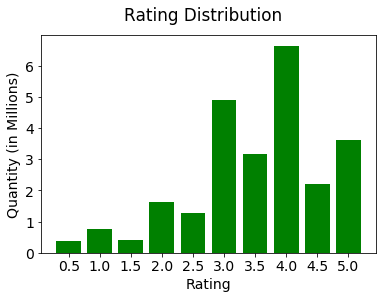

In [18]:
plt.bar(vc['rating'], vc['count(1)'] / 1e6, color='g')
plt.xlabel('Rating')
plt.ylabel('Quantity (in Millions)')
plt.suptitle('Rating Distribution')
plt.savefig('graphs/ratings_dist.png', bbox_inches='tight');

In [19]:
spark.sql("""SELECT AVG(rating) AS avgRating FROM ratings""").show()

+-----------------+
|        avgRating|
+-----------------+
|3.533854451353085|
+-----------------+



## 1

In [20]:
# 1
# user’s enjoyment of movies across different genres
# - i.e. for users who highly rate action movies, do they tend to highly rate other specific genres as well, like adventure or horror?

# get users avg rating and avg rating for each genre

df1_avg = spark.sql("""
SELECT userId, 'all' as genres, AVG(rating) AS AvgRating, 
        COUNT(rating) as numRatings FROM ratings 
GROUP BY userId
""")

df1 = spark.sql("""
SELECT userId, genres, AVG(rating) as avgRating, 
        COUNT(rating) as numRatings FROM ratings 
LEFT JOIN exp_movies ON ratings.movieId = exp_movies.movieId 
GROUP BY userId, genres""")

df1.show(5)

df1_final = df1.unionAll(df1_avg)

+------+-------+-----------------+----------+
|userId| genres|        avgRating|numRatings|
+------+-------+-----------------+----------+
|    33|  Drama|4.205882352941177|        17|
|    47|Western|              4.0|         3|
|    71| Action|             4.25|        16|
|   139|Musical|             3.25|         2|
|   163|    War|             3.75|         2|
+------+-------+-----------------+----------+
only showing top 5 rows



## 2

In [21]:
# 2
# based on ratings, have certain genres trended upwards or downwards in quality over time
# by year, all ratings
df2 = spark.sql("""
SELECT genres, year(timestamp_seconds(CAST(timestamp AS INT))) as ratingYear, 
        AVG(rating) as avgRating, COUNT(rating) as numRatings FROM ratings r
LEFT JOIN exp_movies em ON r.movieId = em.movieId
GROUP BY ratingYear, genres
HAVING ratingYear != 1995
ORDER BY ratingYear ASC
""")

df2.show(5)

+---------+----------+------------------+----------+
|   genres|ratingYear|         avgRating|numRatings|
+---------+----------+------------------+----------+
|Film-Noir|      1996|3.6026529996985226|      3317|
|    Crime|      1996|3.6233931709521934|    256639|
|      War|      1996| 3.958106131134459|     75190|
|Animation|      1996|3.6951026245603185|     77613|
|  Musical|      1996|3.6497807555083477|     73434|
+---------+----------+------------------+----------+
only showing top 5 rows



In [22]:
df2p = df2.toPandas()

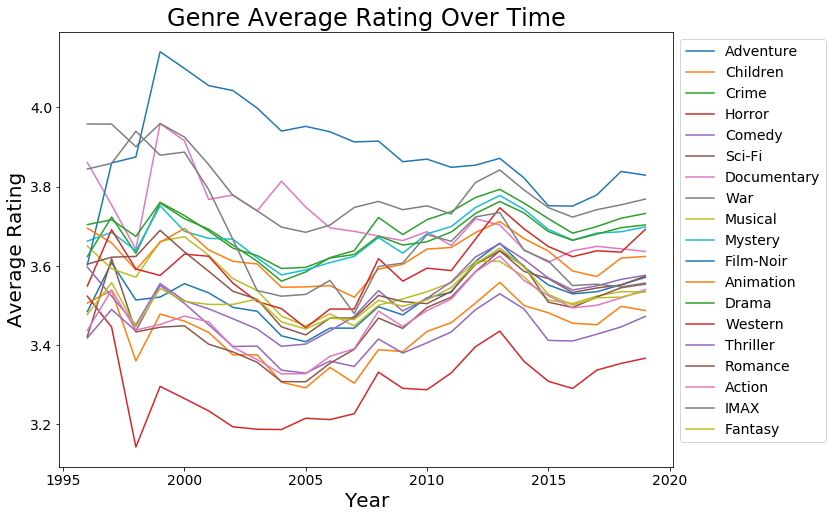

In [23]:
fig, ax = plt.subplots(figsize=(11,8))
for genre in genres:
    temp_df = df2p[df2p['genres'] == genre]
    temp_df.plot(x='ratingYear', y='avgRating', label=genre, ax=ax)

plt.title('Genre Average Rating Over Time', size=24)
plt.xlabel('Year', size=20)
plt.ylabel('Average Rating', size=20)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('graphs/q2.png', bbox_inches='tight');

In [24]:
pvt = pd.pivot_table(df2p[df2p['genres'] != '(no genres listed)'], values='avgRating', index=['genres'],
                    columns=['ratingYear'], aggfunc=np.mean).fillna(0)

In [25]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(pvt)

# sort df by clusters
pvt['clusters'] = kmeans.labels_
pvt = pvt.sort_values(by='clusters')
clust = pvt['clusters'].copy()
pvt.drop(['clusters'], axis=1, inplace=True)

In [26]:
# get clusters...for some reason
clusters = {}
for cl, genre in zip(kmeans.labels_, pvt.index.tolist()):
    if cl not in clusters:
        clusters[cl] = []
    clusters[cl].append(genre)
clusters

{5: ['Western', 'Romance', 'Musical', 'Comedy'],
 0: ['Adventure', 'Crime', 'Horror', 'Documentary', 'Children', 'Action'],
 2: ['Thriller', 'Fantasy', 'Drama', 'Animation', 'War'],
 4: ['Film-Noir', 'Sci-Fi'],
 1: ['IMAX'],
 3: ['Mystery']}

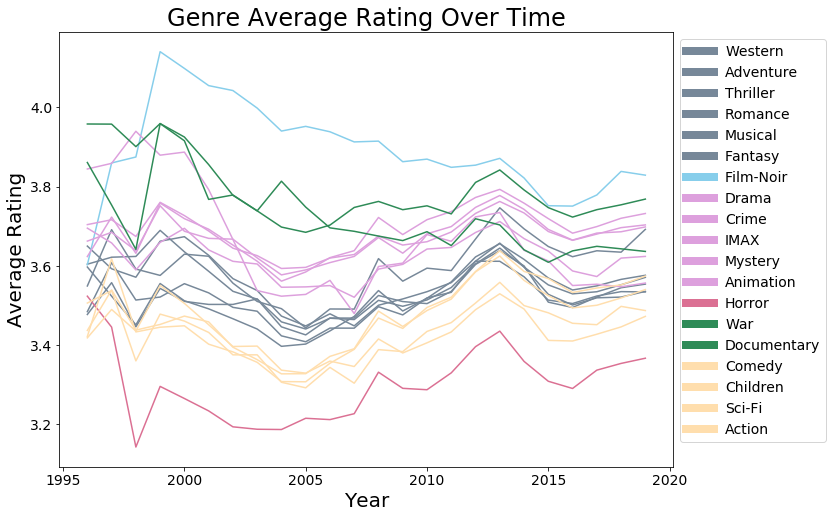

In [27]:
clc = {0: 'lightslategray', 1: 'skyblue', 2: 'plum', 5: 'navajowhite', 3: 'palevioletred', 4: 'seagreen'}

fig, ax = plt.subplots(figsize=(11, 8))

for i, genre in enumerate(pvt.index.tolist()):
    pvt.loc[genre, :].plot(label=genre, ax=ax, c=clc[clust[i]])

plt.title('Genre Average Rating Over Time', size=24)
plt.xlabel('Year', size=20)
plt.ylabel('Average Rating', size=20)

leg = plt.legend(bbox_to_anchor=(1,1))
for line in leg.get_lines(): # https://stackoverflow.com/a/48296983
    line.set_linewidth(8.0)
    
plt.savefig('graphs/q2_kmeans.png', bbox_inches='tight');

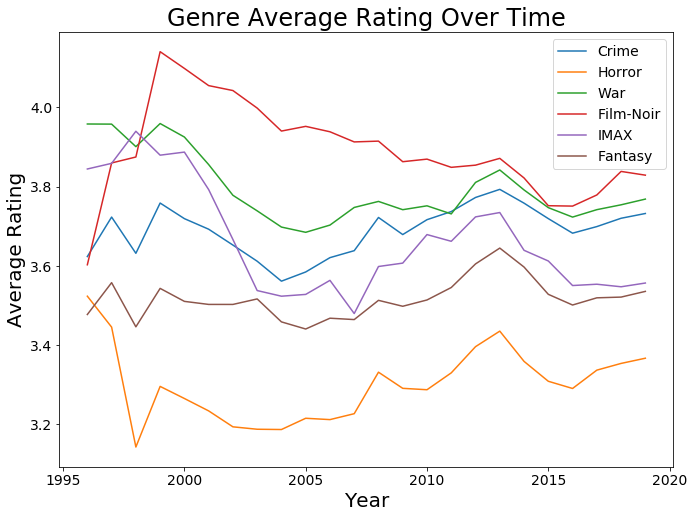

In [28]:
fig, ax = plt.subplots(figsize=(11,8))
for genre in genres:
    if genre not in ['Film-Noir', 'War', 'Horror', 'Crime', 'Fantasy', 'IMAX']: 
        continue
    temp_df = df2p[df2p['genres'] == genre]
    temp_df.plot(x='ratingYear', y='avgRating', label=genre, ax=ax)

plt.title('Genre Average Rating Over Time', size=24)
plt.xlabel('Year', size=20)
plt.ylabel('Average Rating', size=20)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('graphs/q2_re.png', bbox_inches='tight');

In [29]:
# 2.5
# by year, average movie rating
df22 = spark.sql("""
SELECT genres, title, year(timestamp_seconds(CAST(timestamp AS INT))) as ratingYear, 
        AVG(rating) as avgRating, COUNT(rating) as numRatings FROM ratings r
LEFT JOIN exp_movies em ON r.movieId = em.movieId
GROUP BY ratingYear, title, genres
HAVING ratingYear != 1995
ORDER BY ratingYear ASC
""")
df22p = df22.toPandas()
df22p.head()

,genres,title,ratingYear,avgRating,numRatings
0,Drama,"Basketball Diaries, The (1995)",1996,3.578815,793
1,Romance,Legends of the Fall (1994),1996,3.598731,6933
2,Comedy,Reckless (1995),1996,2.950276,181
3,Comedy,Grease 2 (1982),1996,2.172414,58
4,Children,Gold Diggers: The Secret of Bear Mountain (1995),1996,3.362205,127


In [30]:
df22pp = df22p.groupby(['genres', 'ratingYear'])['avgRating'].mean()
df22pp

genres              ratingYear
(no genres listed)  2011          2.950000
                    2012          2.333333
                    2013          2.500000
                    2014          2.500000
                    2015          2.979056
                                    ...   
Western             2015          3.188148
                    2016          3.146714
                    2017          3.193696
                    2018          3.136573
                    2019          3.218111
Name: avgRating, Length: 465, dtype: float64

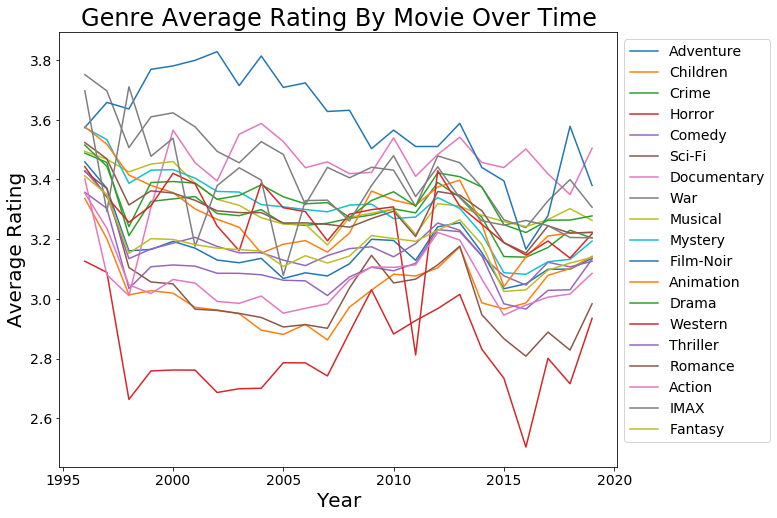

In [31]:
fig, ax = plt.subplots(figsize=(10,8))
for genre in genres:
    df22pp[genre].plot(x='ratingYear', y='avgRating', label=genre, ax=ax)

plt.title('Genre Average Rating By Movie Over Time', size=24)
plt.xlabel('Year', size=20)
plt.ylabel('Average Rating', size=20)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('graphs/q2_5.png', bbox_inches='tight');

## 3

In [32]:
# 3
# do certain tags more-often live in certain genres than others
# - similarly, do certain tags lead to better ratings in one genre than another



## 4

In [33]:
# 4
# as ratings and tags are timestamped, 
# ... are certain genres more popular during certain times of the year

df4 = spark.sql("""
SELECT genres, month(timestamp_seconds(CAST(timestamp AS INT))) as ratingMonth, 
        AVG(rating) as avgRating, COUNT(rating) as numRatings FROM ratings r
LEFT JOIN exp_movies em ON r.movieId = em.movieId
GROUP BY ratingMonth, genres
ORDER BY ratingMonth ASC
""")

df4.show(5)

+---------+-----------+------------------+----------+
|   genres|ratingMonth|         avgRating|numRatings|
+---------+-----------+------------------+----------+
|   Sci-Fi|          1|3.4687455131635625|    383065|
|   Horror|          1|3.2895001795797247|    169841|
|Adventure|          1|3.5133895652073464|    519397|
|   Comedy|          1| 3.420627472096136|    794872|
|    Drama|          1|3.6759538502542233|    975520|
+---------+-----------+------------------+----------+
only showing top 5 rows



In [34]:
df4p = df4.toPandas()

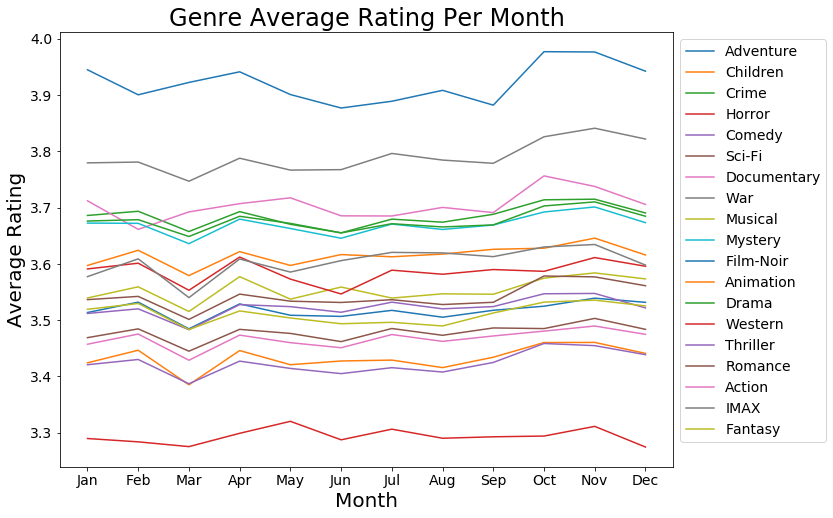

In [35]:
fig, ax = plt.subplots(figsize=(11,8))
for genre in genres:
    temp_df = df4p[df4p['genres'] == genre]
    temp_df.plot(x='ratingMonth', y='avgRating', label=genre, ax=ax)

plt.title('Genre Average Rating Per Month', size=24)
plt.xlabel('Month', size=20)
plt.ylabel('Average Rating', size=20)
plt.xticks(list(range(1,13)), months)
plt.legend(bbox_to_anchor=(1,1));
plt.savefig('graphs/q4.png', bbox_inches='tight');

In [36]:
# 4.5
# get average rating per genre
spark.sql("""
SELECT genres, AVG(rating) as avgRating, 
    COUNT(rating) as numRated FROM exp_movies
RIGHT JOIN ratings ON ratings.movieId = exp_movies.movieId
GROUP BY genres
""").show()

+------------------+------------------+--------+
|            genres|         avgRating|numRated|
+------------------+------------------+--------+
|             Crime| 3.685043693003225| 4190259|
|           Romance|3.5427121571630567| 4497291|
|          Thriller|3.5229643285084498| 6763272|
|         Adventure| 3.517444633654892| 5832424|
|             Drama| 3.677184674800756|10962833|
|               War|3.7914657875591984| 1267346|
|       Documentary|3.7052805249822454|  322449|
|           Fantasy|   3.5115889157486| 2831585|
|           Mystery| 3.670169244577933| 2010995|
|           Musical| 3.554715987107105|  964252|
|         Animation| 3.614946348438093| 1630987|
|         Film-Noir|3.9257281769386028|  247227|
|(no genres listed)| 3.326379239118188|   26627|
|              IMAX|3.6037121959523324| 1063279|
|            Horror|3.2935633075659174| 1892183|
|           Western|3.5857553061515595|  483731|
|            Comedy|3.4239925478057365| 8926230|
|          Children|

## 5

In [37]:
# 5
# plot tags that lead to a better-rated movie among users. 
# for tags with count over 10, average rating

df5 = spark.sql("""
SELECT tag, AVG(rating) AS avgRating, COUNT(tag) as numTagged FROM tags
LEFT JOIN ratings ON (tags.movieId = ratings.movieId AND tags.userId = ratings.userId)
GROUP BY tag
HAVING numTagged > 100
ORDER BY avgRating DESC
""")

In [38]:
df5.show(10)

+------------------+------------------+---------+
|               tag|         avgRating|numTagged|
+------------------+------------------+---------+
|             10/10|             4.875|      123|
|           awesome| 4.701754385964913|      121|
|       masterpiece| 4.585450346420323|      501|
|          must see| 4.560483870967742|      131|
|     good dialogue| 4.530534351145038|      406|
|      good science| 4.521367521367521|      121|
|    epic adventure|4.5144927536231885|      152|
|prospect preferred|               4.5|      406|
|   powerful ending| 4.490942028985507|      568|
|       great story| 4.481132075471698|      110|
+------------------+------------------+---------+
only showing top 10 rows



In [39]:
# 6
# movies from different years

# blah this one

df6 = spark.sql("""
SELECT LEFT(RIGHT(title, 5), 4) as year,  
        AVG(rating) as avgRating FROM movies
RIGHT JOIN ratings ON movies.movieId = ratings.movieId
GROUP BY year
""")
df6

DataFrame[year: string, avgRating: double]

In [40]:
# 1 - done
# 2 - done - plotted
# 3 - 
# 4 - done - plotted
# 5 - done
# 6 - scraped

# Top Rated...

In [41]:
# top avg rated movies, genres, tags - slide 1

In [42]:
tm = spark.sql("""
SELECT ratings.movieId, first(title), AVG(rating) as avgRating, COUNT(rating) as numRatings FROM ratings
LEFT JOIN movies ON ratings.movieId = movies.movieId
GROUP BY ratings.movieId
HAVING numRatings > 20
ORDER BY avgRating DESC
""")

tm.show(5)
tmp = tm.toPandas()

+-------+--------------------+------------------+----------+
|movieId|        first(title)|         avgRating|numRatings|
+-------+--------------------+------------------+----------+
| 171011|Planet Earth II (...| 4.483096085409253|      1124|
| 159817| Planet Earth (2006)| 4.464796794504865|      1747|
|    318|Shawshank Redempt...| 4.413576004516335|     81482|
| 170705|Band of Brothers ...| 4.398598820058997|      1356|
| 171495|              Cosmos|4.3267148014440435|       277|
+-------+--------------------+------------------+----------+
only showing top 5 rows



In [43]:
tmp.columns = ['movieId', 'Title', 'Avg Rating', 'Number of Ratings']
tmp.index = [x+1 for x in tmp.index.tolist()]
tmp.drop(['movieId'], axis=1).head(10)

,Title,Avg Rating,Number of Ratings
1,Planet Earth II (2016),4.483096,1124
2,Planet Earth (2006),4.464797,1747
3,"Shawshank Redemption, The (1994)",4.413576,81482
4,Band of Brothers (2001),4.398599,1356
5,Cosmos,4.326715,277
6,"Godfather, The (1972)",4.324336,52498
7,Blue Planet II (2017),4.289833,659
8,"Usual Suspects, The (1995)",4.284353,55366
9,Obsession (1965),4.277778,36
10,Twin Peaks (1989),4.267361,288


In [61]:
print(tmp.drop(['movieId'], axis=1).head(10).to_latex())

\begin{tabular}{llrr}
\toprule
{} &                             Title &  Avg Rating &  Number of Ratings \\
\midrule
1  &            Planet Earth II (2016) &    4.483096 &               1124 \\
2  &               Planet Earth (2006) &    4.464797 &               1747 \\
3  &  Shawshank Redemption, The (1994) &    4.413576 &              81482 \\
4  &           Band of Brothers (2001) &    4.398599 &               1356 \\
5  &                            Cosmos &    4.326715 &                277 \\
6  &             Godfather, The (1972) &    4.324336 &              52498 \\
7  &             Blue Planet II (2017) &    4.289833 &                659 \\
8  &        Usual Suspects, The (1995) &    4.284353 &              55366 \\
9  &                  Obsession (1965) &    4.277778 &                 36 \\
10 &                 Twin Peaks (1989) &    4.267361 &                288 \\
\bottomrule
\end{tabular}



In [44]:
tg = spark.sql("""
SELECT genres, AVG(rating) as avgRating, COUNT(rating) as numRatings FROM ratings r
LEFT JOIN exp_movies e ON r.movieId = e.movieId
GROUP BY genres
HAVING numRatings > 20
ORDER BY avgRating DESC
""")

tg.show(5)
tgp = tg.toPandas()

+-----------+------------------+----------+
|     genres|         avgRating|numRatings|
+-----------+------------------+----------+
|  Film-Noir|3.9257281769386028|    247227|
|        War|3.7914657875591984|   1267346|
|Documentary|3.7052805249822454|    322449|
|      Crime| 3.685043693003225|   4190259|
|      Drama| 3.677184674800756|  10962833|
+-----------+------------------+----------+
only showing top 5 rows



In [45]:
tgp.columns = ['Genre', 'Avg Rating', 'Number of Ratings']
tgp.index = [x+1 for x in tgp.index.tolist()]
tgp.head(10)

,Genre,Avg Rating,Number of Ratings
1,Film-Noir,3.925728,247227
2,War,3.791466,1267346
3,Documentary,3.705281,322449
4,Crime,3.685044,4190259
5,Drama,3.677185,10962833
6,Mystery,3.670169,2010995
7,Animation,3.614946,1630987
8,IMAX,3.603712,1063279
9,Western,3.585755,483731
10,Musical,3.554716,964252


In [70]:
print(tgp.to_latex())

\begin{tabular}{llrr}
\toprule
{} &               Genre &  Avg Rating &  Number of Ratings \\
\midrule
1  &           Film-Noir &    3.925728 &             247227 \\
2  &                 War &    3.791466 &            1267346 \\
3  &         Documentary &    3.705281 &             322449 \\
4  &               Crime &    3.685044 &            4190259 \\
5  &               Drama &    3.677185 &           10962833 \\
6  &             Mystery &    3.670169 &            2010995 \\
7  &           Animation &    3.614946 &            1630987 \\
8  &                IMAX &    3.603712 &            1063279 \\
9  &             Western &    3.585755 &             483731 \\
10 &             Musical &    3.554716 &             964252 \\
11 &             Romance &    3.542712 &            4497291 \\
12 &            Thriller &    3.522964 &            6763272 \\
13 &           Adventure &    3.517445 &            5832424 \\
14 &             Fantasy &    3.511589 &            2831585 \\
15 &           

In [67]:
tgp.sort_values(by='Number of Ratings')

,Genre,Avg Rating,Number of Ratings
19,(no genres listed),3.326379,26627
1,Film-Noir,3.925728,247227
3,Documentary,3.705281,322449
9,Western,3.585755,483731
10,Musical,3.554716,964252
8,IMAX,3.603712,1063279
2,War,3.791466,1267346
7,Animation,3.614946,1630987
20,Horror,3.293563,1892183
6,Mystery,3.670169,2010995


In [46]:
tt = spark.sql("""
SELECT tag, AVG(rating) as avgRating, COUNT(rating) as numRatings FROM ratings r
LEFT JOIN tags t ON (r.movieId = t.movieId AND r.userId = t.userId)
GROUP BY tag
HAVING numRatings > 20
ORDER BY avgRating DESC
""")

tt.show(5)
ttp = tt.toPandas()

+---------------+-----------------+----------+
|            tag|        avgRating|numRatings|
+---------------+-----------------+----------+
|       FAVORITE| 4.96969696969697|        33|
|       delights|4.966666666666667|        30|
| rewatch worthy|              4.9|        45|
|best movie ever|4.897058823529412|        34|
|        5 stars|4.863636363636363|        22|
+---------------+-----------------+----------+
only showing top 5 rows



In [47]:
ttp.columns = ['Tag', 'Avg Rating', 'Number of Ratings']
ttp.head(5)

,Tag,Avg Rating,Number of Ratings
0,FAVORITE,4.969697,33
1,delights,4.966667,30
2,rewatch worthy,4.900000,45
3,best movie ever,4.897059,34
4,5 stars,4.863636,22


In [72]:
print(ttp.head(5).to_latex())

\begin{tabular}{llrr}
\toprule
{} &              Tag &  Avg Rating &  Number of Ratings \\
\midrule
0 &         FAVORITE &    4.969697 &                 33 \\
1 &         delights &    4.966667 &                 30 \\
2 &   rewatch worthy &    4.900000 &                 45 \\
3 &  best movie ever &    4.897059 &                 34 \\
4 &          5 stars &    4.863636 &                 22 \\
\bottomrule
\end{tabular}



# Most Relevant Tag

In [48]:
# most relevant tag for each genre (average of movies in that genre) (except 'original' and 'mentor')
mrt = spark.sql("""
SELECT genres, tag, maxAvgRel FROM 
(
    SELECT genres, max_by(tagId, avgRel) as tagId, 
        max(avgRel) as maxAvgRel 
    FROM 
    (
        SELECT 
            genres, tagId, AVG(relevance) as avgRel
        FROM genomescores gs
        RIGHT JOIN exp_movies em 
            ON em.movieId = gs.movieId
        GROUP BY genres, tagId
        HAVING (tagId != 742 AND tagId != 646)
    ) atr
    GROUP BY genres
) mx
LEFT JOIN genometags gt 
    ON mx.tagId = gt.tagId
""")
mrt.show()

+------------------+-------------+-------------------+
|            genres|          tag|          maxAvgRel|
+------------------+-------------+-------------------+
|             Crime| great ending| 0.5439006449631449|
|           Romance|relationships|  0.492798324150597|
|          Thriller|     suspense| 0.5682364508844561|
|         Adventure|    adventure| 0.5393073988055739|
|             Drama|        drama|0.49992159763313615|
|               War|          war| 0.6440079646017699|
|       Documentary|  documentary| 0.8030331703910614|
|           Fantasy|fantasy world| 0.5658872549019607|
|           Mystery| great ending| 0.5805879289215686|
|           Musical|      musical| 0.6861507128309573|
|         Animation|    animation| 0.8459130886426592|
|         Film-Noir|    film noir|  0.790215579710145|
|(no genres listed)| storytelling| 0.5575111111111113|
|              IMAX|       action| 0.6397268786127166|
|            Horror|       horror| 0.7139733221476509|
|         

In [49]:
mrt_df = mrt.toPandas()

In [50]:
mrt_df1 = mrt_df[mrt_df['tag'] != mrt_df['genres'].apply(lambda x: x.lower())]
mrt_df1.columns = ['Genre', 'Tag', 'Avg Relevance']
mrt_df1

,Genre,Tag,Avg Relevance
0,Crime,great ending,0.543901
1,Romance,relationships,0.492798
2,Thriller,suspense,0.568236
7,Fantasy,fantasy world,0.565887
8,Mystery,great ending,0.580588
11,Film-Noir,film noir,0.790216
12,(no genres listed),storytelling,0.557511
13,IMAX,action,0.639727
15,Western,gunfight,0.766891
17,Children,family,0.641897


In [51]:
# most relevant tag for each movie (average of movies in that genre)
spark.sql("""
SELECT movieId, max_by(tagId, relevance) as maxTag, max(relevance) as maxScore 
FROM genomescores gs
GROUP BY movieId
""").show(10)

+-------+------+------------------+
|movieId|maxTag|          maxScore|
+-------+------+------------------+
| 102684|   671|           0.96875|
| 106022|  1036|0.9977499999999999|
| 108791|   235|0.9962500000000001|
|   1090|   127|            0.9975|
| 112911|    89|               1.0|
| 115713|    59|               1.0|
| 115770|   297|0.9557500000000001|
| 119655|   377|            0.9975|
| 120478|   315|0.9604999999999999|
| 134851|   704|             0.946|
+-------+------+------------------+
only showing top 10 rows



# Times

In [73]:
# times may be slightly different than those in the paper as I may have reran it since

### 4

In [52]:
%%timeit 
# 4
# as ratings and tags are timestamped, 
# ... are certain genres more popular during certain times of the year

df4 = spark.sql("""
SELECT genres, month(timestamp_seconds(CAST(timestamp AS INT))) as ratingMonth, 
        AVG(rating) as avgRating, COUNT(rating) as numRatings FROM ratings r
LEFT JOIN exp_movies em ON r.movieId = em.movieId
GROUP BY ratingMonth, genres
ORDER BY ratingMonth ASC
""")

df4.show(5)

+---------+-----------+------------------+----------+
|   genres|ratingMonth|         avgRating|numRatings|
+---------+-----------+------------------+----------+
|   Sci-Fi|          1|3.4687455131635625|    383065|
|   Horror|          1|3.2895001795797247|    169841|
|Adventure|          1|3.5133895652073464|    519397|
|    Drama|          1|3.6759538502542233|    975520|
|   Comedy|          1| 3.420627472096136|    794872|
+---------+-----------+------------------+----------+
only showing top 5 rows

+---------+-----------+------------------+----------+
|   genres|ratingMonth|         avgRating|numRatings|
+---------+-----------+------------------+----------+
|   Sci-Fi|          1|3.4687455131635625|    383065|
|   Horror|          1|3.2895001795797247|    169841|
|Adventure|          1|3.5133895652073464|    519397|
|    Drama|          1|3.6759538502542233|    975520|
|   Comedy|          1| 3.420627472096136|    794872|
+---------+-----------+------------------+----------+
onl

### Join

In [53]:
%%timeit

spark.sql("""
SELECT * FROM ratings
LEFT JOIN movies ON ratings.movieId = movies.movieId
""").show(1)

+------+-------+------+----------+-------+-------------------+--------------------+
|userId|movieId|rating| timestamp|movieId|              title|              genres|
+------+-------+------+----------+-------+-------------------+--------------------+
|     1|    296|   5.0|1147880044|    296|Pulp Fiction (1994)|Comedy|Crime|Dram...|
+------+-------+------+----------+-------+-------------------+--------------------+
only showing top 1 row

+------+-------+------+----------+-------+-------------------+--------------------+
|userId|movieId|rating| timestamp|movieId|              title|              genres|
+------+-------+------+----------+-------+-------------------+--------------------+
|     1|    296|   5.0|1147880044|    296|Pulp Fiction (1994)|Comedy|Crime|Dram...|
+------+-------+------+----------+-------+-------------------+--------------------+
only showing top 1 row

+------+-------+------+----------+-------+-------------------+--------------------+
|userId|movieId|rating| time

In [54]:
%%timeit 

ratings_df.join(movies_df, how='left', on='movieId').show(1)

+-------+------+------+----------+-------------------+--------------------+
|movieId|userId|rating| timestamp|              title|              genres|
+-------+------+------+----------+-------------------+--------------------+
|    296|     1|   5.0|1147880044|Pulp Fiction (1994)|Comedy|Crime|Dram...|
+-------+------+------+----------+-------------------+--------------------+
only showing top 1 row

+-------+------+------+----------+-------------------+--------------------+
|movieId|userId|rating| timestamp|              title|              genres|
+-------+------+------+----------+-------------------+--------------------+
|    296|     1|   5.0|1147880044|Pulp Fiction (1994)|Comedy|Crime|Dram...|
+-------+------+------+----------+-------------------+--------------------+
only showing top 1 row

+-------+------+------+----------+-------------------+--------------------+
|movieId|userId|rating| timestamp|              title|              genres|
+-------+------+------+----------+------

### Bigger Join

In [55]:
%%timeit

spark.sql("""
SELECT * FROM ratings
LEFT JOIN exp_movies ON ratings.movieId = exp_movies.movieId
""").show(1)

+------+-------+------+----------+---+-------+-------------------+--------+
|userId|movieId|rating| timestamp|_c0|movieId|              title|  genres|
+------+-------+------+----------+---+-------+-------------------+--------+
|     1|    296|   5.0|1147880044|292|    296|Pulp Fiction (1994)|Thriller|
+------+-------+------+----------+---+-------+-------------------+--------+
only showing top 1 row

+------+-------+------+----------+---+-------+-------------------+--------+
|userId|movieId|rating| timestamp|_c0|movieId|              title|  genres|
+------+-------+------+----------+---+-------+-------------------+--------+
|     1|    296|   5.0|1147880044|292|    296|Pulp Fiction (1994)|Thriller|
+------+-------+------+----------+---+-------+-------------------+--------+
only showing top 1 row

+------+-------+------+----------+---+-------+-------------------+--------+
|userId|movieId|rating| timestamp|_c0|movieId|              title|  genres|
+------+-------+------+----------+---+--

In [56]:
%%timeit 

ratings_df.join(e_movies_df, how='left', on='movieId').show(1)

+-------+------+------+----------+---+-------------------+--------+
|movieId|userId|rating| timestamp|_c0|              title|  genres|
+-------+------+------+----------+---+-------------------+--------+
|    296|     1|   5.0|1147880044|292|Pulp Fiction (1994)|Thriller|
+-------+------+------+----------+---+-------------------+--------+
only showing top 1 row

+-------+------+------+----------+---+-------------------+--------+
|movieId|userId|rating| timestamp|_c0|              title|  genres|
+-------+------+------+----------+---+-------------------+--------+
|    296|     1|   5.0|1147880044|292|Pulp Fiction (1994)|Thriller|
+-------+------+------+----------+---+-------------------+--------+
only showing top 1 row

+-------+------+------+----------+---+-------------------+--------+
|movieId|userId|rating| timestamp|_c0|              title|  genres|
+-------+------+------+----------+---+-------------------+--------+
|    296|     1|   5.0|1147880044|292|Pulp Fiction (1994)|Thriller|


### Group By

In [57]:
%%timeit

spark.sql("""
SELECT movieId, AVG(rating) as avgRating FROM ratings
GROUP BY movieId
""").show(1)

+-------+-----------------+
|movieId|        avgRating|
+-------+-----------------+
|    296|4.188912039361382|
+-------+-----------------+
only showing top 1 row

+-------+-----------------+
|movieId|        avgRating|
+-------+-----------------+
|    296|4.188912039361382|
+-------+-----------------+
only showing top 1 row

+-------+-----------------+
|movieId|        avgRating|
+-------+-----------------+
|    296|4.188912039361382|
+-------+-----------------+
only showing top 1 row

+-------+-----------------+
|movieId|        avgRating|
+-------+-----------------+
|    296|4.188912039361382|
+-------+-----------------+
only showing top 1 row

+-------+-----------------+
|movieId|        avgRating|
+-------+-----------------+
|    296|4.188912039361382|
+-------+-----------------+
only showing top 1 row

+-------+-----------------+
|movieId|        avgRating|
+-------+-----------------+
|    296|4.188912039361382|
+-------+-----------------+
only showing top 1 row

+-------+-------

In [58]:
ratings_df = ratings_df.withColumn("rating", ratings_df["rating"].cast(FloatType()))

In [59]:
%%timeit

ratings_df.groupby('movieId').mean('rating').show(1)

+-------+-----------------+
|movieId|      avg(rating)|
+-------+-----------------+
|    296|4.188912039361382|
+-------+-----------------+
only showing top 1 row

+-------+-----------------+
|movieId|      avg(rating)|
+-------+-----------------+
|    296|4.188912039361382|
+-------+-----------------+
only showing top 1 row

+-------+-----------------+
|movieId|      avg(rating)|
+-------+-----------------+
|    296|4.188912039361382|
+-------+-----------------+
only showing top 1 row

+-------+-----------------+
|movieId|      avg(rating)|
+-------+-----------------+
|    296|4.188912039361382|
+-------+-----------------+
only showing top 1 row

+-------+-----------------+
|movieId|      avg(rating)|
+-------+-----------------+
|    296|4.188912039361382|
+-------+-----------------+
only showing top 1 row

+-------+-----------------+
|movieId|      avg(rating)|
+-------+-----------------+
|    296|4.188912039361382|
+-------+-----------------+
only showing top 1 row

+-------+-------